In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv("/kaggle/input/health/heart_disease_data.csv")

print(data.head())

print(data.info())

print(data.isnull().sum())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5 

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

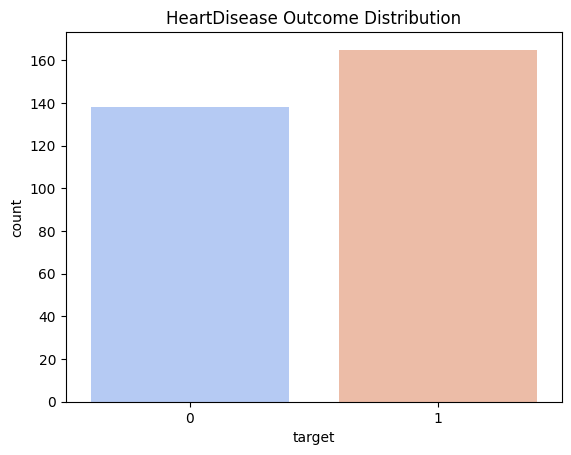

In [4]:
print(data.describe())

sns.countplot(x=data['target'], palette='coolwarm')
plt.title("HeartDisease Outcome Distribution")
plt.show()

In [5]:
X = data.drop(columns=["target"])
y = data["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (242, 13)
Testing Data Shape: (61, 13)


In [7]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [100, 200, 300] 
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("XGBoost Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("XGBoost Testing  Accuracy:", accuracy_score(y_test, y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.6}
XGBoost Training Accuracy: 0.987603305785124
XGBoost Testing  Accuracy: 0.8524590163934426
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [9]:
param_grid2 = {
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.3, 0.5], 
}

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        n_estimators=200,
        subsample=0.6,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search2.fit(X_train, y_train)

print("Best Parameters after second tuning:", grid_search2.best_params_)

best_xgb2 = xgb.XGBClassifier(**grid_search2.best_params_, 
                              colsample_bytree=1.0, 
                              learning_rate=0.01, 
                              n_estimators=200, 
                              subsample=0.6, 
                              use_label_encoder=False, 
                              eval_metric="logloss")

best_xgb2.fit(X_train, y_train)

y_pred_train2 = best_xgb2.predict(X_train)
y_pred_test2 = best_xgb2.predict(X_test)

print("XGBoost Training Accuracy (After Second Tuning):", accuracy_score(y_train, y_pred_train2))
print("XGBoost Testing Accuracy (After Second Tuning):", accuracy_score(y_test, y_pred_test2))
print("XGBoost Classification Report (After Second Tuning):\n", classification_report(y_test, y_pred_test2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters after second tuning: {'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 5}
XGBoost Training Accuracy (After Second Tuning): 0.8636363636363636
XGBoost Testing Accuracy (After Second Tuning): 0.8688524590163934
XGBoost Classification Report (After Second Tuning):
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [10]:
import pickle
import joblib
import xgboost as xgb

with open("xgboost_heartdisease_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)

joblib.dump(best_xgb2, "xgboost_heartdisease_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!
